In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
# Do not change this cell

def calc_hist(image):
    '''
    calculate image histogram
    You completed this method in previous assignment
    input(s):
    image (ndarray): input image
    output(s):
    hist (ndarray): computed input image histogram
    '''
    hist = np.zeros(256,dtype=int)

    for i in range(256):
        hist[i] = np.sum(image == i)
    return hist

## Q1

In [ ]:
def hist_matching(src_image, ref_image):
  '''
  don't use libraries
  You can use calc_hist method
  input(s):
    src_image (ndarray): source image
    ref_image (ndarray): reference image
  output(s):
    output_image (ndarray): transformation of source image so that its histogram matches histogram of refrence image 
  '''
  output_image = src_image.copy()
  ############
  # Your code
  # Start
  def channel_wise_matching(src_channel, ref_channel):
    output_channel = src_channel.copy()

    src_hist = calc_hist(src_channel)
    ref_hist = calc_hist(ref_channel)
    
    def most_similar(rcdf, elem):
      dis = np.abs(rcdf - elem)

      return np.argmin(dis)

    def cdf(hist):
      cdf_hist = np.zeros(256,dtype=int)

      for i in range(256):
        cdf_hist[i] = np.sum(hist[:i+1])
      
      return cdf_hist

    src_cdf = cdf(src_hist) / (src_channel.shape[0] * src_channel.shape[1])
    ref_cdf = cdf(ref_hist) / (ref_channel.shape[0] * ref_channel.shape[1])

    hist_matching_dict = {}

    for index in range(256):
      hist_matching_dict[index] = most_similar(ref_cdf, src_cdf[index])

    for row in range(src_channel.shape[0]):
      for col in range(src_channel.shape[1]):
        output_channel[row, col] = hist_matching_dict[src_channel[row, col]]

    return output_channel

  for i in range(src_image.shape[2]):
    output_image[:, :, i] = channel_wise_matching(src_image[:, :, i], ref_image[:, :, i])
  # End
  return output_image

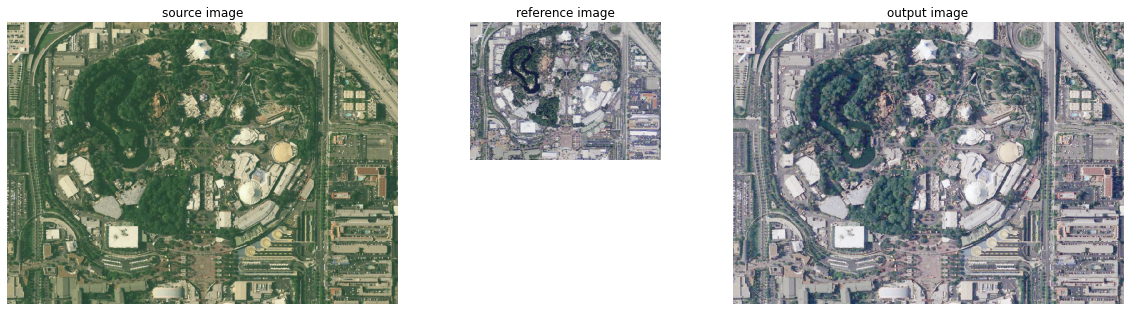

In [ ]:
# Do not change this cell
src = cv2.imread('hist_match_src.jpg')
ref = cv2.imread('hist_match_ref.jpg')
fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 3), 
                 axes_pad=1,  
                 )

grid[0].imshow(src[:,:,::-1])
grid[0].set_title('source image')
grid[0].axis('off')
grid[1].imshow(ref[:,:,::-1])
grid[1].set_title('reference image')
grid[1].axis('off')
grid[2].imshow(hist_matching(src,ref)[:,:,::-1])
grid[2].set_title('output image')
grid[2].axis('off')
plt.show()

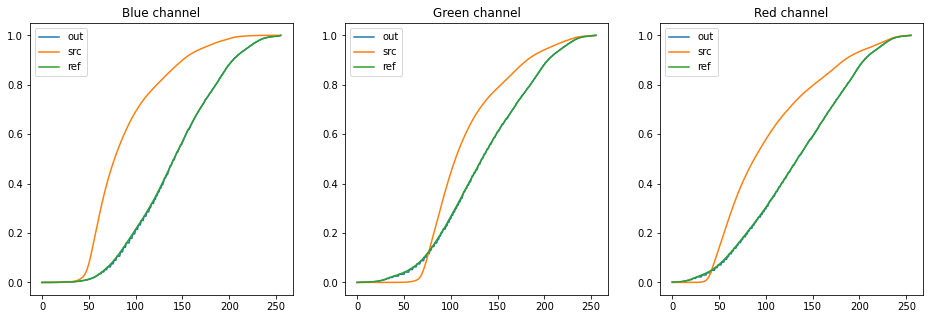

In [ ]:
# Plotting CDF diagram for each channel
# Do not change this cell
fig = plt.figure(figsize= (16, 5))
channels = [(0, 'Blue channel'), (1, 'Green channel'), (2, 'Red channel')]
output = hist_matching(src,ref)
for channel, title in channels:
    fig.add_subplot(1, 3, channel+ 1)
    a = calc_hist(output[:,:,channel])
    a = np.cumsum(a)
    a = a / a[-1]
    b = calc_hist(src[:,:,channel])
    b = np.cumsum(b)
    b = b / b[-1]
    c = calc_hist(ref[:,:,channel])
    c = np.cumsum(c)
    c = c / c[-1]
    plt.plot(a,label='out')
    plt.plot(b,label='src')
    plt.plot(c,label='ref')
    plt.legend()
    plt.title(title)

## Q2
### part b

In [ ]:
def equalize_hist(image):
    '''
    You can use libraries.
    input(s):
    image (ndarray): input image
    output(s):
    output_image (ndarray): enhanced image with histogram equalization
    '''
    output_image = image.copy()
    ############
    # Your code
    # Start
    # histo = calc_hist(image)
    # unnorm_cdf = np.cumsum(histo)
    # cdf = unnorm_cdf / unnorm_cdf[-1]

    # equalization = np.rint(cdf * 255)

    # for row in range(image.shape[0]):
    #   for col in range(image.shape[1]):
    #     output_image[row, col] = equalization[image[row, col]]
    output_image = cv2.equalizeHist(image)
    # End
    return output_image

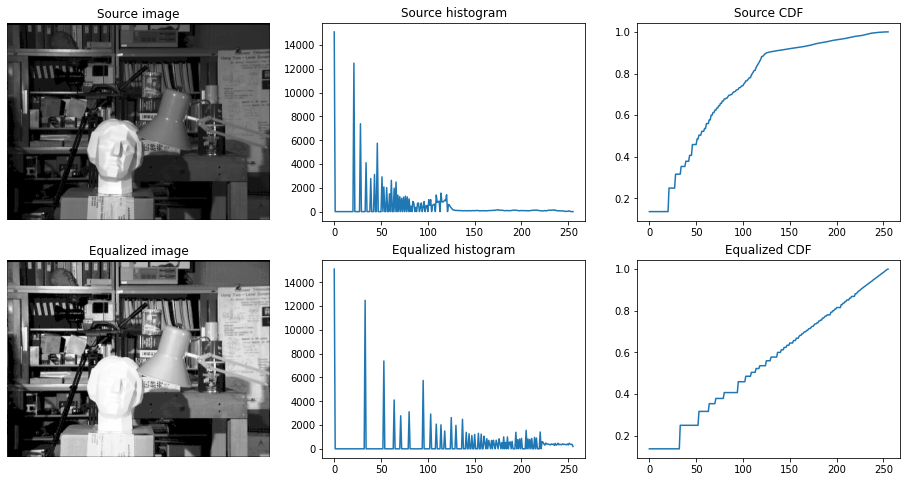

In [ ]:
# Do not change this cell
fig = plt.figure(figsize= (16, 8))
src = cv2.imread('img_improvment.png', cv2.IMREAD_GRAYSCALE)
fig.add_subplot(2,3,1)
plt.imshow(src, cmap='gray')
plt.title('Source image')
plt.axis('off')

fig.add_subplot(2,3,2)
plt.plot(calc_hist(src))
plt.title('Source histogram')

src_cum_hist = np.cumsum(calc_hist(src))
src_cdf = src_cum_hist / src_cum_hist[-1]
fig.add_subplot(2,3,3)
plt.plot(src_cdf)
plt.title('Source CDF')

equalized_img = equalize_hist(src)
fig.add_subplot(2,3,4)
plt.imshow(equalized_img, cmap='gray')
plt.title('Equalized image')
plt.axis('off')

fig.add_subplot(2,3,5)
plt.plot(calc_hist(equalized_img))
plt.title('Equalized histogram')

eq_cum_hist = np.cumsum(calc_hist(equalized_img))
eq_cdf = eq_cum_hist / eq_cum_hist[-1]
fig.add_subplot(2,3,6)
plt.plot(eq_cdf)
plt.title('Equalized CDF')

plt.show()

## Q3
### part a

In [4]:
def ACE(image, gridSize):
    '''
    you can just use the equalize function of OpenCV for each grid
    You can use OpenCV built-in tools for applying padding
    Use second method for ACE implementation (calculating transition function for each pixel)
    input(s):
    image (ndarray): input image
    gridSize (tuple): window size for calculating histogram equalization
    output(s):
    output (ndarray): improved image
    '''
    output = image.copy()
    #your code here
    # Start 
    rborder = gridSize[0] // 2
    cborder = gridSize[1] // 2

    padded_img = cv2.copyMakeBorder(image, cborder, cborder, rborder, rborder, cv2.BORDER_REFLECT)
    shape = padded_img.shape
    for i in range(rborder, shape[0] - rborder):
      for j in range(cborder, shape[1] - cborder):
        region = padded_img[i-rborder:i+rborder+1, j-cborder:j+cborder+1]
        eh = cv2.equalizeHist(region)
        output[i-rborder, j-cborder] = eh[eh.shape[0] // 2, eh.shape[1] // 2]
    # End

    return output

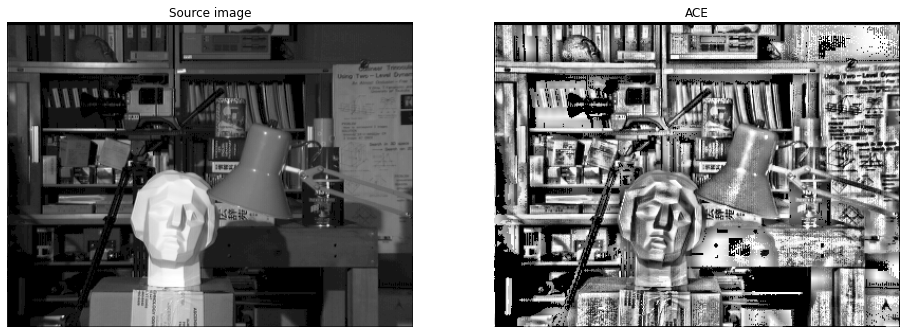

In [7]:
# Note that you are not supposed to get an excellent result with the default grid size
# The correctness of your implementation is important. it is optional to change the grid size. 
fig = plt.figure(figsize= (16, 8))
src = cv2.imread('img_improvment.png', cv2.IMREAD_GRAYSCALE)
fig.add_subplot(1,2,1)
plt.imshow(src, cmap='gray')
plt.title('Source image')
plt.axis('off')

ace_img = ACE(src,(20, 20))      # You get better result with with higher grid size
fig.add_subplot(1,2,2)
plt.imshow(ace_img, cmap='gray')
plt.title('ACE')
plt.axis('off')

plt.show()

### part b

In [9]:
def CLAHE(image, gridSize, clip_limit):
    '''
    you can just use the equalize function of OpenCV for each grid
    You can use OpenCV built-in tools for applying padding
    Use second method for ACE implementation (calculating transition function for each pixel)
    input(s):
    image (ndarray): input image
    gridSize (tuple): window size for calculating histogram equalization
    clip_limit (int): threshold for contrast limiting
    output(s):
    output (ndarray): improved image
    '''
    output = image.copy()
    #your code here
    # Start 
    rborder = gridSize[0] // 2
    cborder = gridSize[1] // 2

    padded_img = cv2.copyMakeBorder(image, cborder, cborder, rborder, rborder, cv2.BORDER_REFLECT)
    shape = padded_img.shape
    for i in range(rborder, shape[0] - rborder):
      for j in range(cborder, shape[1] - cborder):
        region = padded_img[i-rborder:i+rborder+1, j-cborder:j+cborder+1]
        
        region_hist = calc_hist(region)
        clipped_hist = np.array([max(elem, 0) for elem in region_hist - clip_limit])
        nums = np.sum(clipped_hist) // 256
        new_region_hist = (region_hist - clipped_hist) + nums
 
        unnorm_cdf = np.cumsum(new_region_hist)
        cdf = unnorm_cdf / unnorm_cdf[-1]
        equalization = np.rint(cdf * 255)

        output[i-rborder, j-cborder] = equalization[padded_img[i, j]]

    # End

    return output

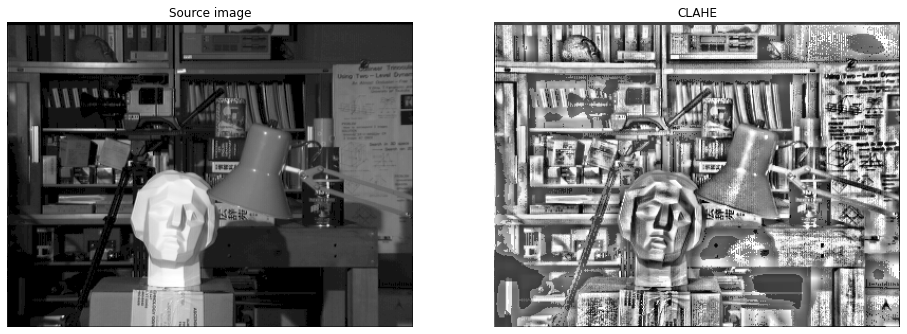

In [13]:
# Note that you are not supposed to get an excellent result with the default grid size
# The correctness of your implementation is important. it is optional to change the grid size.
# Change the clip_limit to get the best result
fig = plt.figure(figsize= (16, 8))
src = cv2.imread('img_improvment.png', cv2.IMREAD_GRAYSCALE)
fig.add_subplot(1,2,1)
plt.imshow(src, cmap='gray')
plt.title('Source image')
plt.axis('off')

clahe_img = CLAHE(src,(20, 20), 100)      # You get better result with with higher grid size
fig.add_subplot(1,2,2)
plt.imshow(clahe_img, cmap='gray')
plt.title('CLAHE')
plt.axis('off')

plt.show()

## Q4
### part a

In [ ]:
def convolve(image, kernel):
    '''
    You can use libraries
    There is no need to add padding
    input(s):
    image (ndarray): input image'
    kernel (ndarray): input kernel
    output(s):
    output (ndarray): filtered image
    '''
    output = image.copy()
    #your code here
    # Start
    output = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    # End
    return output

### part b

In [1]:
def get_gaussian(size, std):
    '''
    Do not use libraries
    input(s):
    size (tuple): height and width of kernel
    std (float): std of gaussian kernel
    output(s):
    kernel (ndarray): gaussian kernel with specified size and std
    '''
    #your code here
    # Start
    ax = np.linspace(-(size[0] - 1) / 2., (size[0] - 1) / 2., size[0])
    gauss = np.exp(-0.5 * (np.square(ax) / np.square(std)))
    kernel = np.outer(gauss, gauss)
    kernel = kernel / np.sum(kernel)    
    # kernel = None
    # End
    return kernel

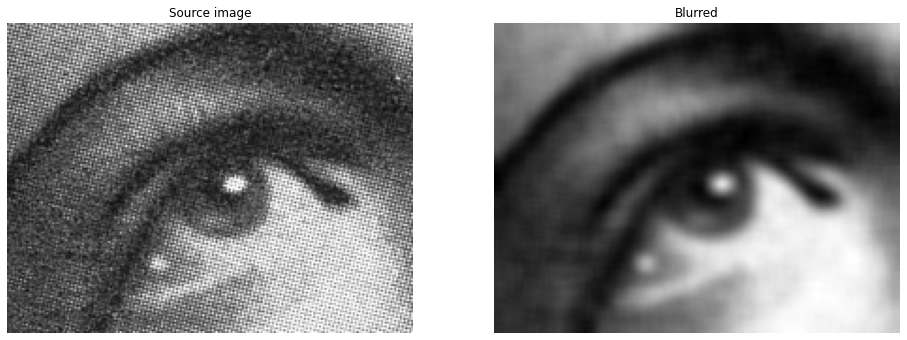

In [ ]:
fig = plt.figure(figsize= (16, 8))
src = cv2.imread('gaussian.png', cv2.IMREAD_GRAYSCALE)
fig.add_subplot(1,2,1)
plt.imshow(src, cmap='gray')
plt.title('Source image')
plt.axis('off')

kernel = get_gaussian((9,9), 10)
output = convolve(src, kernel)

fig.add_subplot(1,2,2)
plt.imshow(output, cmap='gray')
plt.title('Blurred')
plt.axis('off')

plt.show()